<h2>Multilevel Modeling(Rolling Window)</h2>

<strong>Author: Diheng Chen</strong>  
<strong>Date: 08/02/2018</strong>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pymc3 import Deterministic,find_MAP,Normal, HalfCauchy, Uniform,Model,StudentT,sample,Laplace

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [4]:
import pymc3 as pm

<h3>Data preprocessing</h3>
<strong>import data</strong>

In [5]:
df=pd.read_pickle('df_pred_all.pkl')
df.tab=df.tab.astype(str)
df.head()

,delivery_date,tab,label_ordered,pred_sales_yoy_main,pred_sales_yoy_ss,sales_actual_yoy,reportdays,reportduration,reportduration_grp,date_diff_announce,panel_sales,transactions,unique_shoppers,avg_ticket,avg_trans_shopper
0,26,1,5,0.000034,-0.041869,-0.0201,83,83.0,80.0,-12,0.0115,-0.0283,-0.0141,0.0410,-0.0143
1,29,1,6,0.009505,-0.014633,0.0242,43,83.0,80.0,-76,0.0260,-0.0249,-0.0225,0.0522,-0.0024
2,30,1,6,0.010592,-0.014111,0.0242,57,83.0,80.0,-62,0.0275,-0.0284,-0.0219,0.0576,-0.0066
3,31,1,6,0.004112,-0.014111,0.0242,77,83.0,80.0,-48,0.0235,-0.0259,-0.0151,0.0507,-0.0108
4,32,1,6,0.002513,-0.013920,0.0242,83,83.0,80.0,-33,0.0218,-0.0230,-0.0124,0.0460,-0.0108


<strong>Drop the company does not have insample data.</strong>

In [6]:
Good_C=df[df.delivery_date<=27].tab.unique()
df=df[df.tab.isin(Good_C)]

<strong>set a lookup table (dict) for each unique company, for indexing</strong>

In [7]:
tabs=df.tab.unique()
num_tabs=len(tabs)
tab_lookup=dict(zip(tabs, range(num_tabs)))

In [8]:
#Number of Companies
Num_Companies=len(tab_lookup)

In [9]:
df['tab_code']=df.tab.replace(tab_lookup).values

<strong>Set train and test samples</strong>  
Fixed Rolling Window: Using 1 year(4Q)'s data to make one step ahead prediction. The company with data in the next period will adopt the FIFO method, and the company without data remains unchanged for train sample.  
Recursive: Initial train sample contains 1 year(15Q4-16Q3). This time the initial data is fixed, and additional observations are added one at a time to the train sample.

In [10]:
#df['delivery_date']=pd.to_datetime(df['delivery_date'])

In [11]:
insample=df[df.delivery_date<=27]
outsample=df[df.delivery_date>27]
insample.reset_index(inplace=True,drop=True)
outsample.reset_index(inplace=True,drop=True)
insample.tail()

,delivery_date,tab,label_ordered,pred_sales_yoy_main,pred_sales_yoy_ss,sales_actual_yoy,reportdays,reportduration,reportduration_grp,date_diff_announce,panel_sales,transactions,unique_shoppers,avg_ticket,avg_trans_shopper,tab_code
567,23,39,5,-0.005131,0.025867,0.0091,36,90.0,90.0,-57,-0.0397,-0.0499,-0.0438,0.0107,-0.0063,35
568,24,39,5,-0.012301,0.025867,0.0091,50,90.0,90.0,-43,-0.0468,-0.0588,-0.0518,0.0127,-0.0074,35
569,25,39,5,-0.002098,0.025867,0.0091,64,90.0,90.0,-29,-0.0337,-0.0543,-0.0493,0.0218,-0.0053,35
570,26,39,5,0.005701,0.025635,0.0091,78,90.0,90.0,-15,-0.0248,-0.0631,-0.0553,0.0409,-0.0083,35
571,27,39,5,-0.004246,0.024824,0.0091,90,90.0,90.0,-1,-0.0333,-0.0638,-0.0534,0.0325,-0.0110,35


<strong>Define Functions for drawing train samples and test samples on Rolling Windows-base</strong>

Rolling with Fixed Window

In [12]:
def draw_train(date,train):
    for tab in tabs:
        temp=outsample[outsample.tab==tab]
        if sum(temp.delivery_date.values==date):
            if(len(train[train.tab==tab])>0):
                train=train.drop(train[train.tab==tab].index[0],axis=0)
            train=pd.concat([train,outsample[(outsample.tab==tab)&(outsample.delivery_date.values==date)]])
            train.reset_index(inplace=True,drop=True)
    return train

Rolling with Recursive Window 

In [13]:
def draw_train_add(date,train):
    for tab in tabs:
        temp=outsample[outsample.tab==tab]
        if sum(temp.delivery_date.values==date):
            train=pd.concat([train,outsample[(outsample.tab==tab)&(outsample.delivery_date.values==date)]])
    train.reset_index(inplace=True,drop=True)
    return train

In [14]:
def draw_test(date,test): 
    for tab in tabs:
        temp=outsample[outsample.tab==tab].copy()   
        test.drop(test[test.tab==tab].index,axis=0,inplace=True)
        if sum(temp.delivery_date.values==date):            
            test=pd.concat([test,temp[temp.delivery_date.values==date]])
            test.reset_index(inplace=True,drop=True) 
    return test

<h3>Functions for Six Hierarchical Models</h3>

<strong>Model 1</strong>  
<strong>Varying intercept without Hierachical Model</strong>  
Using the panel_sales as variable
    $$y_i=\alpha_{j[i]}+\beta x_i+\epsilon_i$$
    $$\epsilon_i\sim N(0,\sigma^2)$$

In [15]:
def model1(X,n):
    #n=1:MAP
    #n=2:MCMC
    #n=3:ADVI
    tab=X.tab.replace(tab_lookup).values
    with Model() as varying_intercept:
        # Priors
        mu_a = Normal('mu_a', mu=0., tau=0.0001)
        sigma_a = HalfCauchy('sigma_a', 5)
        # Random intercepts
        a = Normal('a', mu=mu_a, sd=sigma_a, shape=Num_Companies)
        # Common slope
        b = Normal('b', mu=0., sd=1e5)
        # Model error
        sd_y = Uniform('sigma_y', lower=0, upper=100)
        #sd_y = HalfCauchy('sigma_b',5)
        # Expected value
        y_hat = a[tab] + b * X.panel_sales
        # Data likelihood
        y_like = Normal('y_like', mu=y_hat, sd=sd_y, observed=X.sales_actual_yoy)
        if n==1:
            estimate=pm.find_MAP(model=varying_intercept)
        elif n==2:
            estimate=pm.sample(500,chains=1,cores=1)
        elif n==3:
            approx = pm.FullRankADVI().fit()
            estimate=approx.sample(5000)
        return estimate

<strong>Model 2</strong>  
<strong>Hierachical Varying intercept Model</strong>  
Using the insample means of sales_actual_yoy of each company as benchmarks  
x=panel_sales 
    $$y_i=\alpha_{j[i]}+\beta x_i+\epsilon_i$$
    $$\alpha_j=\gamma_0+\gamma_1 benchmark_j+\xi_j$$
    $$\xi_j\sim N(0,\sigma_{\alpha}^2)$$

In [16]:
def model2(X,n):
    #n=1:MAP
    #n=2:MCMC
    #n=3:ADVI
    tab=X.tab.replace(tab_lookup).values
    with Model() as hierarchical_intercept:
        # Priors
        sigma_a = HalfCauchy('sigma_a', 5)
        gamma_0 = Normal('gamma_0', mu=0., sd=1e5)
        gamma_1 = Normal('gamma_1', mu=0., sd=1e5)
        # benchmark model for intercept
        mu_a = gamma_0 + gamma_1*X['initial'].values
        # company variation not explained by benchmark
        eps_a = Normal('eps_a', mu=0, sd=sigma_a, shape=Num_Companies)
        a = Deterministic('a', mu_a + eps_a[tab])
        # Common slope
        b = Normal('b', mu=0., sd=1e5)
        # Model error
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        # Expected value
        y_hat = a + b * X['panel_sales']
        # Data likelihood
        y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=X['sales_actual_yoy'])
        if n==1:
            estimate = pm.find_MAP(model=hierarchical_intercept)
        elif n==2:
            estimate=pm.sample(500,chains=1,cores=1)
        elif n==3:
            approx = pm.FullRankADVI().fit()
            estimate=approx.sample(5000)
    return estimate

<strong>Model 3</strong>  
<strong>Varying slope without Hierachical Model</strong>   
Using the panel_sales as variable
    $$y_i=\alpha+\beta_{j[i]} x_i+\epsilon_i$$
    $$\epsilon_i\sim N(0,\sigma^2)$$

In [17]:
def model3(X,n):
    tab=X.tab.replace(tab_lookup).values
    with Model() as varying_slope:
        # Priors
        mu_b = Normal('mu_b', mu=0., sd=1e5)
        sigma_b = HalfCauchy('sigma_b', 5)
        # Common intercepts
        a = Normal('a', mu=0., sd=1e5)
        # Random slopes
        b = Normal('b', mu=mu_b, sd=sigma_b, shape=Num_Companies)
        # Model error
        sigma_y = HalfCauchy('sigma_y',5)
        # Expected value
        y_hat = a + b[tab] * X.panel_sales
        # Data likelihood
        y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=X.sales_actual_yoy)
        if n==1:
            estimate = pm.find_MAP(model=varying_slope)
        elif n==2:
            estimate=pm.sample(500,chains=1,cores=1)
        elif n==3:
            approx = pm.FullRankADVI().fit()
            estimate=approx.sample(5000)
    return estimate

<strong>Model 4</strong>  
<strong>Varying slope adding group-level predictor Model</strong>  
Using the insample means of sales_actual_yoy of each company as benchmarks  
x=panel_sales 
    $$y_i=\alpha+\beta_{j[i]} x_i+\epsilon_i$$
    $$\beta_j=\gamma_0+\gamma_1 benchmark_j+\xi_j$$
    $$\xi_j\sim N(0,\sigma_{\beta}^2)$$

In [18]:
def model4(X,n):
    tab=X.tab.replace(tab_lookup).values
    with Model() as hierarchical_slope:
        # Priors
        sigma_b = HalfCauchy('sigma_b', 5)
        gamma_0 = Normal('gamma_0', mu=0., sd=1e5)
        gamma_1 = Normal('gamma_1', mu=0., sd=1e5)
        # benchmark model for slope
        mu_b = gamma_0 + gamma_1*X['initial'].values
        # company variation not explained by benchmark
        eps_b = Normal('eps_b', mu=0, sd=sigma_b, shape=Num_Companies)
        b = Deterministic('b', mu_b + eps_b[tab])
        # Common intercept
        a = Normal('a', mu=0., sd=1e5)
        # Model error
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        # Expected value
        y_hat = a + b * X['panel_sales']
        # Data likelihood
        y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=X['sales_actual_yoy'])
        if n==1:
            estimate = pm.find_MAP(model=hierarchical_slope)
        elif n==2:
            estimate=pm.sample(500,chains=1,cores=1)
        elif n==3:
            approx = pm.FullRankADVI().fit()
            estimate=approx.sample(5000)
    return estimate

<strong>Model 5</strong>  
<strong>Varying slope and intercept without Hierachical Model</strong>  
Using the panel_sales as variable  
    $$y_i=\alpha_{j[i]}+\beta_{j[i]} x_i+\epsilon_i$$
    $$\epsilon_i\sim N(0,\sigma^2)$$

In [19]:
def model5(X,n):
    tab=X.tab.replace(tab_lookup).values
    with Model() as varying_intercept_slope:
        mu_a = Normal('mu_a', mu=0., sd=1e5)
        sigma_a = HalfCauchy('sigma_a', 5)
        mu_b = Normal('mu_b', mu=0., sd=1e5)
        sigma_b = HalfCauchy('sigma_b', 5)
        # Random intercepts
        a = Normal('a', mu=mu_a, sd=sigma_a, shape=Num_Companies)
        # Random slopes
        b = Normal('b', mu=mu_b, sd=sigma_b, shape=Num_Companies)
        # Model error
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        # Expected value
        y_hat = a[tab] + b[tab] * X.panel_sales
        # Data likelihood
        y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=X.sales_actual_yoy)
        if n==1:
            estimate = pm.find_MAP(model=varying_intercept_slope)
        elif n==2:
            estimate=pm.sample(500,chains=1,cores=1)
        elif n==3:
            approx = pm.FullRankADVI().fit()
            estimate=approx.sample(5000)
    return estimate

<strong>Model 6</strong>  
<strong>Varying slope adding group-level predictor Model</strong>  
Using the insample means of sales_actual_yoy of each company as benchmarks  
x=panel_sales 
    $$y_i=\alpha_{j[i]}+\beta_{j[i]} x_i+\epsilon_i$$
    $$\alpha_j=\gamma_0+\gamma_1 benchmark_j+\xi_{1j}$$
    $$\beta_j=\gamma_2+\gamma_3 benchmark_j+\xi_{2j}$$
    $$\xi_{1j}\sim N(0,\sigma_{\alpha}^2)$$
    $$\xi_{2j}\sim N(0,\sigma_{\beta}^2)$$

In [20]:
def model6(X,n):
    tab=X.tab.replace(tab_lookup).values
    with Model() as hierarchical_slope_intercept:
        # Priors
        sigma_a = HalfCauchy('sigma_a', 5)
        gamma_0 = Normal('gamma_0', mu=0., sd=1e5)
        gamma_1 = Normal('gamma_1', mu=0., sd=1e5)
        sigma_b = HalfCauchy('sigma_b', 5)
        gamma_2 = Normal('gamma_2', mu=0., sd=1e5)
        gamma_3 = Normal('gamma_3', mu=0., sd=1e5)
        # benchmark model for intercept
        mu_a = gamma_0 + gamma_1*X['initial'].values
        # benchmark model for slope
        mu_b = gamma_2 + gamma_3*X['initial'].values
        # company variation not explained by benchmark
        eps_a = Normal('eps_a', mu=0, sd=sigma_a, shape=Num_Companies)
        a = Deterministic('a', mu_a + eps_a[tab])
        eps_b = Normal('eps_b', mu=0, sd=sigma_b, shape=Num_Companies)
        b = Deterministic('b', mu_b + eps_b[tab])
        # Model error
        sigma_y = Uniform('sigma_y', lower=0, upper=100)
        # Expected value
        y_hat = a + b * X['panel_sales']
        # Data likelihood
        y_like = Normal('y_like', mu=y_hat, sd=sigma_y, observed=X['sales_actual_yoy'])
        if n==1:
            estimate = pm.find_MAP(model=hierarchical_slope_intercept)
        elif n==2:
            estimate=pm.sample(1000,chains=1,cores=1)
        elif n==3:
            approx = pm.FullRankADVI().fit()
            estimate=approx.sample(5000)
    return estimate

<h3>Functions for Forecasting</h3>

In [21]:
def pred1(a,b,test):
    return test.apply(lambda x: a[x.tab_code] + b* x.panel_sales, axis=1).values

In [22]:
def pred2(gamma0,gamma1,a,b,test,benchmark):
    return test.apply(lambda x: gamma0+gamma1*benchmark[x.tab_code]+
                           a[x.tab_code] + b* x.panel_sales, axis=1).values

In [23]:
def pred3(a,b,test):
    return test.apply(lambda x:a + b[x.tab_code]* x.panel_sales, axis=1).values

In [24]:
def pred4(gamma0,gamma1,a,b,test,benchmark):
    return test.apply(lambda x:a+ (gamma0+gamma1*benchmark[x.tab_code]+b[x.tab_code])* 
                           x.panel_sales, axis=1).values

In [25]:
def pred5(a,b,test):
    return test.apply(lambda x:a[x.tab_code] + b[x.tab_code]* x.panel_sales, axis=1).values

In [26]:
def pred6(gamma0,gamma1,gamma2,gamma3,a,b,test,benchmark):
    return test.apply(lambda x:(gamma0+gamma1*benchmark[x.tab_code]+a[x.tab_code])+ 
                           (gamma2+gamma3*benchmark[x.tab_code]+b[x.tab_code])* x.panel_sales, axis=1).values

<h3>Functions for Calculating Metrics</h3>

In [27]:
def MAD(real,pred):
    return np.median(np.abs(real-pred))

<h3>Functions for Models Running</h3>

Running function for models without benchmark(Model 1,3,5)

In [28]:
#Fixed Window for MAP(1)
def model_running(n):
    train=insample.copy()
    #use the first date's data of outsample as initial test sample
    test=outsample[outsample.delivery_date==outsample_date[0]]
    pred_yoy=np.array([])
    real_yoy=np.array([])
    map_estimate=eval('model'+str(n))(train,1)
    pred_yoy=np.append(pred_yoy,eval('pred'+str(n))(map_estimate['a'],map_estimate['b'],test))
    real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    insample_e= {'insample_MAD': []}
    for i in range(len(outsample_date)-1):
        date0=outsample_date[i]
        date1=outsample_date[i+1]
        #compute insample error
        insample_e['insample_MAD'].append(MAD(eval('pred'+str(n))(map_estimate['a'],map_estimate['b'],train),train.sales_actual_yoy))
        train=draw_train(date0,train)
        test=draw_test(date1,test)
        map_estimate=eval('model'+str(n))(train,1)
        pred_yoy=np.append(pred_yoy,eval('pred'+str(n))(map_estimate['a'],map_estimate['b'],test))
        real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    return pd.DataFrame(insample_e),MAD(pred_yoy,real_yoy)

In [29]:
#Fixed Window for MCMC(2) and ADVI(3)
def model_running_SAMPLE(n,method=2):
    train=insample.copy()
    test=outsample[outsample.delivery_date==outsample_date[0]]
    pred_yoy=np.array([])
    real_yoy=np.array([])
    trace=eval('model'+str(n))(train,method)
    pred_yoy=np.append(pred_yoy,eval('pred'+str(n))(trace['a'].mean(axis=0),trace['b'].mean(axis=0),test))
    real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    insample_e= {'insample_MAD': []}
    for i in range(len(outsample_date)-1):
        date0=outsample_date[i]
        date1=outsample_date[i+1]
        insample_e['insample_MAD'].append(MAD(eval('pred'+str(n))(trace['a'].mean(axis=0),trace['b'].mean(axis=0),train),train.sales_actual_yoy))
        train=draw_train(date0,train)
        test=draw_test(date1,test)
        trace=eval('model'+str(n))(train,method)
        pred_yoy=np.append(pred_yoy,eval('pred'+str(n))(trace['a'].mean(axis=0),trace['b'].mean(axis=0),test))
        real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    return pd.DataFrame(insample_e),MAD(pred_yoy,real_yoy)

In [30]:
#Recursive Window for MAP(1)
def model_running_add(n):
    train=insample.copy()
    test=outsample[outsample.delivery_date==outsample_date[0]]
    pred_yoy=np.array([])
    real_yoy=np.array([])
    map_estimate=eval('model'+str(n))(train,1)
    pred_yoy=np.append(pred_yoy,eval('pred'+str(n))(map_estimate['a'],map_estimate['b'],test))
    real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    insample_e= {'insample_MAD': []}
    for i in range(len(outsample_date)-1):
        date0=outsample_date[i]
        date1=outsample_date[i+1]
        insample_e['insample_MAD'].append(MAD(eval('pred'+str(n))(map_estimate['a'],map_estimate['b'],train),train.sales_actual_yoy))
        train=draw_train_add(date0,train)
        test=draw_test(date1,test)
        map_estimate=eval('model'+str(n))(train,1)
        pred_yoy=np.append(pred_yoy,eval('pred'+str(n))(map_estimate['a'],map_estimate['b'],test))
        real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    return pd.DataFrame(insample_e),MAD(pred_yoy,real_yoy)

In [31]:
#Recursive Window for MCMC(2) and ADVI(3)
def model_running_add_SAMPLE(n,method=2):
    train=insample.copy()
    test=outsample[outsample.delivery_date==outsample_date[0]]
    pred_yoy=np.array([])
    real_yoy=np.array([])
    trace=eval('model'+str(n))(train,method)
    pred_yoy=np.append(pred_yoy,eval('pred'+str(n))(trace['a'].mean(axis=0),trace['b'].mean(axis=0),test))
    real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    insample_e= {'insample_MAD': []}
    for i in range(len(outsample_date)-1):
        date0=outsample_date[i]
        date1=outsample_date[i+1]
        insample_e['insample_MAD'].append(MAD(eval('pred'+str(n))(trace['a'].mean(axis=0),trace['b'].mean(axis=0),train),train.sales_actual_yoy))
        train=draw_train_add(date0,train)
        test=draw_test(date1,test)
        trace=eval('model'+str(n))(train,method)
        pred_yoy=np.append(pred_yoy,eval('pred'+str(n))(trace['a'].mean(axis=0),trace['b'].mean(axis=0),test))
        real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    return pd.DataFrame(insample_e),MAD(pred_yoy,real_yoy)

Running function for models with benchmark(Model 2,4,6)

In [32]:
#Fixed Window for MAP(1)
def model_running_benchmark(n):
    train=insample.copy()
    test=outsample[outsample.delivery_date==outsample_date[0]]
    #test=outsample.groupby('tab',as_index=False).first()
    benchmark=train.groupby('tab')['sales_actual_yoy'].mean().values
    benchmark_lookup=dict(zip(tabs, benchmark))
    train['initial']=train.tab.replace(benchmark_lookup).values
    pred_yoy=np.array([])
    real_yoy=np.array([])
    map_estimate=eval('model'+str(n))(train,1)
    insample_e= {'insample_MAD': []}
    if n==2:
        pred_yoy=np.append(pred_yoy,pred2(map_estimate['gamma_0'],map_estimate['gamma_1'],
                                          map_estimate['eps_a'],map_estimate['b'],test,benchmark))
    elif n==4:
        pred_yoy=np.append(pred_yoy,pred4(map_estimate['gamma_0'],map_estimate['gamma_1'],
                                          map_estimate['a'],map_estimate['eps_b'],test,benchmark))
    elif n==6:
        pred_yoy=np.append(pred_yoy,pred6(map_estimate['gamma_0'],map_estimate['gamma_1'],map_estimate['gamma_2'],
                   map_estimate['gamma_3'],map_estimate['eps_a'],map_estimate['eps_b'],test,benchmark))
    real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    for i in range(len(outsample_date)-1):
        date0=outsample_date[i]
        date1=outsample_date[i+1] 
        train=draw_train(date0,train)
        test=draw_test(date1,test)
        benchmark=train.groupby('tab')['sales_actual_yoy'].mean().values
        benchmark_lookup=dict(zip(tabs, benchmark))
        train['initial']=train.tab.replace(benchmark_lookup).values
        map_estimate=eval('model'+str(n))(train,1)
        if n==2:
            insample_e['insample_MAD'].append(MAD(pred2(map_estimate['gamma_0'],map_estimate['gamma_1'],
                                    map_estimate['eps_a'],map_estimate['b'],train,benchmark),train.sales_actual_yoy))
            pred_yoy=np.append(pred_yoy,pred2(map_estimate['gamma_0'],map_estimate['gamma_1'],
                                              map_estimate['eps_a'],map_estimate['b'],test,benchmark))
        elif n==4:
            insample_e['insample_MAD'].append(MAD(pred4(map_estimate['gamma_0'],map_estimate['gamma_1'],
                                    map_estimate['a'],map_estimate['eps_b'],train,benchmark),train.sales_actual_yoy))
            pred_yoy=np.append(pred_yoy,pred4(map_estimate['gamma_0'],map_estimate['gamma_1'],
                                              map_estimate['a'],map_estimate['eps_b'],test,benchmark))
        elif n==6:
            insample_e['insample_MAD'].append(MAD(pred6(map_estimate['gamma_0'],map_estimate['gamma_1'],map_estimate['gamma_2'],
                       map_estimate['gamma_3'],map_estimate['eps_a'],map_estimate['eps_b'],train,benchmark),train.sales_actual_yoy))
            pred_yoy=np.append(pred_yoy,pred6(map_estimate['gamma_0'],map_estimate['gamma_1'],map_estimate['gamma_2'],
                       map_estimate['gamma_3'],map_estimate['eps_a'],map_estimate['eps_b'],test,benchmark))
        real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    return pd.DataFrame(insample_e),MAD(pred_yoy,real_yoy)

In [33]:
#Fixed Window for MCMC(2) and ADVI(3)
def model_running_benchmark_SAMPLE(n,method=2):
    train=insample.copy()
    test=outsample[outsample.delivery_date==outsample_date[0]]
    #test=outsample.groupby('tab',as_index=False).first()
    benchmark=train.groupby('tab')['sales_actual_yoy'].mean().values
    benchmark_lookup=dict(zip(tabs, benchmark))
    train['initial']=train.tab.replace(benchmark_lookup).values
    pred_yoy=np.array([])
    real_yoy=np.array([])
    trace=eval('model'+str(n))(train,method)
    insample_e= {'insample_MAD': []}
    if n==2:
        pred_yoy=np.append(pred_yoy,pred2(trace['gamma_0'].mean(),trace['gamma_1'].mean(),
                                          trace['eps_a'].mean(axis=0),trace['b'].mean(axis=0),test,benchmark))
    elif n==4:
        pred_yoy=np.append(pred_yoy,pred4(trace['gamma_0'].mean(),trace['gamma_1'].mean(),trace['a'].mean(axis=0),
                                          trace['eps_b'].mean(axis=0),test,benchmark))
    elif n==6:
        pred_yoy=np.append(pred_yoy,pred6(trace['gamma_0'].mean(),trace['gamma_1'].mean(),trace['gamma_2'].mean(),
               trace['gamma_3'].mean(),trace['eps_a'].mean(axis=0),trace['eps_b'].mean(axis=0),test,benchmark))
    real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    for i in range(len(outsample_date)-1):
        date0=outsample_date[i]
        date1=outsample_date[i+1]
        train=draw_train_add(date0,train)
        test=draw_test(date1,test)
        benchmark=train.groupby('tab')['sales_actual_yoy'].mean().values
        benchmark_lookup=dict(zip(tabs, benchmark))
        train['initial']=train.tab.replace(benchmark_lookup).values
        trace=eval('model'+str(n))(train,method)
        if n==2:
            insample_e['insample_MAD'].append(MAD(pred2(trace['gamma_0'].mean(),trace['gamma_1'].mean(),
                                          trace['eps_a'].mean(axis=0),trace['b'].mean(axis=0),train,benchmark),train.sales_actual_yoy))
            pred_yoy=np.append(pred_yoy,pred2(trace['gamma_0'].mean(),trace['gamma_1'].mean(),
                                          trace['eps_a'].mean(axis=0),trace['b'].mean(axis=0),test,benchmark))
        elif n==4:
            insample_e['insample_MAD'].append(MAD(pred4(trace['gamma_0'].mean(),trace['gamma_1'].mean(),trace['a'].mean(axis=0),
                                          trace['eps_b'].mean(axis=0),train,benchmark),train.sales_actual_yoy))
            pred_yoy=np.append(pred_yoy,pred4(trace['gamma_0'].mean(),trace['gamma_1'].mean(),trace['a'].mean(axis=0),
                                          trace['eps_b'].mean(axis=0),test,benchmark))
        elif n==6:
            insample_e['insample_MAD'].append(MAD(pred6(trace['gamma_0'].mean(),trace['gamma_1'].mean(),trace['gamma_2'].mean(),
               trace['gamma_3'].mean(),trace['eps_a'].mean(axis=0),trace['eps_b'].mean(axis=0),train,benchmark),train.sales_actual_yoy))
            pred_yoy=np.append(pred_yoy,pred6(trace['gamma_0'].mean(),trace['gamma_1'].mean(),trace['gamma_2'].mean(),
               trace['gamma_3'].mean(),trace['eps_a'].mean(axis=0),trace['eps_b'].mean(axis=0),test,benchmark))
        real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    return pd.DataFrame(insample_e),MAD(pred_yoy,real_yoy)

In [34]:
#Recursive Window for MAP(1)
def model_running_add_benchmark(n):
    train=insample.copy()
    test=outsample[outsample.delivery_date==outsample_date[0]]
    #test=outsample.groupby('tab',as_index=False).first()
    benchmark=train.groupby('tab')['sales_actual_yoy'].mean().values
    benchmark_lookup=dict(zip(tabs, benchmark))
    train['initial']=train.tab.replace(benchmark_lookup).values
    pred_yoy=np.array([])
    real_yoy=np.array([])
    map_estimate=eval('model'+str(n))(train,1)
    if n==2:
        pred_yoy=np.append(pred_yoy,pred2(map_estimate['gamma_0'],map_estimate['gamma_1'],
                                          map_estimate['eps_a'],map_estimate['b'],test,benchmark))
    elif n==4:
        pred_yoy=np.append(pred_yoy,pred4(map_estimate['gamma_0'],map_estimate['gamma_1'],
                                          map_estimate['a'],map_estimate['eps_b'],test,benchmark))
    elif n==6:
        pred_yoy=np.append(pred_yoy,pred6(map_estimate['gamma_0'],map_estimate['gamma_1'],map_estimate['gamma_2'],
                   map_estimate['gamma_3'],map_estimate['eps_a'],map_estimate['eps_b'],test,benchmark))
    real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    insample_e= {'insample_MAD': []}
    for i in range(len(outsample_date)-1):
        date0=outsample_date[i]
        date1=outsample_date[i+1]
        train=draw_train_add(date0,train)
        test=draw_test(date1,test)
        benchmark=train.groupby('tab')['sales_actual_yoy'].mean().values
        benchmark_lookup=dict(zip(tabs, benchmark))
        train['initial']=train.tab.replace(benchmark_lookup).values
        map_estimate=eval('model'+str(n))(train,1)
        if n==2:
            insample_e['insample_MAD'].append(MAD(pred2(map_estimate['gamma_0'],map_estimate['gamma_1'],
                                    map_estimate['eps_a'],map_estimate['b'],train,benchmark),train.sales_actual_yoy))
            pred_yoy=np.append(pred_yoy,pred2(map_estimate['gamma_0'],map_estimate['gamma_1'],
                                              map_estimate['eps_a'],map_estimate['b'],test,benchmark))
        elif n==4:
            insample_e['insample_MAD'].append(MAD(pred4(map_estimate['gamma_0'],map_estimate['gamma_1'],
                                    map_estimate['a'],map_estimate['eps_b'],train,benchmark),train.sales_actual_yoy))
            pred_yoy=np.append(pred_yoy,pred4(map_estimate['gamma_0'],map_estimate['gamma_1'],
                                              map_estimate['a'],map_estimate['eps_b'],test,benchmark))
        elif n==6:
            insample_e['insample_MAD'].append(MAD(pred6(map_estimate['gamma_0'],map_estimate['gamma_1'],map_estimate['gamma_2'],
                       map_estimate['gamma_3'],map_estimate['eps_a'],map_estimate['eps_b'],train,benchmark),train.sales_actual_yoy))
            pred_yoy=np.append(pred_yoy,pred6(map_estimate['gamma_0'],map_estimate['gamma_1'],map_estimate['gamma_2'],
                       map_estimate['gamma_3'],map_estimate['eps_a'],map_estimate['eps_b'],test,benchmark))
        real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    return pd.DataFrame(insample_e),MAD(pred_yoy,real_yoy)

In [35]:
#Recursive Window for MCMC(2) and ADVI(3)
def model_running_add_benchmark_SAMPLE(n,method=2):
    train=insample.copy()
    test=outsample[outsample.delivery_date==outsample_date[0]]
    #test=outsample.groupby('tab',as_index=False).first()
    benchmark=train.groupby('tab')['sales_actual_yoy'].mean().values
    benchmark_lookup=dict(zip(tabs, benchmark))
    train['initial']=train.tab.replace(benchmark_lookup).values
    pred_yoy=np.array([])
    real_yoy=np.array([])
    trace=eval('model'+str(n))(train,method)
    insample_e= {'insample_MAD': []}
    if n==2:
        pred_yoy=np.append(pred_yoy,pred2(trace['gamma_0'].mean(),trace['gamma_1'].mean(),
                                          trace['eps_a'].mean(axis=0),trace['b'].mean(axis=0),test,benchmark))
    elif n==4:
        pred_yoy=np.append(pred_yoy,pred4(trace['gamma_0'].mean(),trace['gamma_1'].mean(),trace['a'].mean(axis=0),
                                          trace['eps_b'].mean(axis=0),test,benchmark))
    elif n==6:
        pred_yoy=np.append(pred_yoy,pred6(trace['gamma_0'].mean(),trace['gamma_1'].mean(),trace['gamma_2'].mean(),
               trace['gamma_3'].mean(),trace['eps_a'].mean(axis=0),trace['eps_b'].mean(axis=0),test,benchmark))
    real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    for i in range(len(outsample_date)-1):
        date0=outsample_date[i]
        date1=outsample_date[i+1]
        train=draw_train(date0,train)
        test=draw_test(date1,test)
        benchmark=train.groupby('tab')['sales_actual_yoy'].mean().values
        benchmark_lookup=dict(zip(tabs, benchmark))
        train['initial']=train.tab.replace(benchmark_lookup).values
        trace=eval('model'+str(n))(train,method)
        if n==2:
            insample_e['insample_MAD'].append(MAD(pred2(trace['gamma_0'].mean(),trace['gamma_1'].mean(),
                                          trace['eps_a'].mean(axis=0),trace['b'].mean(axis=0),train,benchmark),train.sales_actual_yoy))
            pred_yoy=np.append(pred_yoy,pred2(trace['gamma_0'].mean(),trace['gamma_1'].mean(),
                                          trace['eps_a'].mean(axis=0),trace['b'].mean(axis=0),test,benchmark))
        elif n==4:
            insample_e['insample_MAD'].append(MAD(pred4(trace['gamma_0'].mean(),trace['gamma_1'].mean(),trace['a'].mean(axis=0),
                                          trace['eps_b'].mean(axis=0),train,benchmark),train.sales_actual_yoy))
            pred_yoy=np.append(pred_yoy,pred4(trace['gamma_0'].mean(),trace['gamma_1'].mean(),trace['a'].mean(axis=0),
                                          trace['eps_b'].mean(axis=0),test,benchmark))
        elif n==6:
            insample_e['insample_MAD'].append(MAD(pred6(trace['gamma_0'].mean(),trace['gamma_1'].mean(),trace['gamma_2'].mean(),
               trace['gamma_3'].mean(),trace['eps_a'].mean(axis=0),trace['eps_b'].mean(axis=0),train,benchmark),train.sales_actual_yoy))
            pred_yoy=np.append(pred_yoy,pred6(trace['gamma_0'].mean(),trace['gamma_1'].mean(),trace['gamma_2'].mean(),
               trace['gamma_3'].mean(),trace['eps_a'].mean(axis=0),trace['eps_b'].mean(axis=0),test,benchmark))
        real_yoy=np.append(real_yoy,test.sales_actual_yoy)
    return pd.DataFrame(insample_e),MAD(pred_yoy,real_yoy)

<h3>Implement</h3>

In [36]:
#Get outsample predition date
outsample_date=np.sort(outsample.delivery_date.unique())

<h3>convergence Test</h3>

Model 1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_a_log__, mu_a]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.21it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


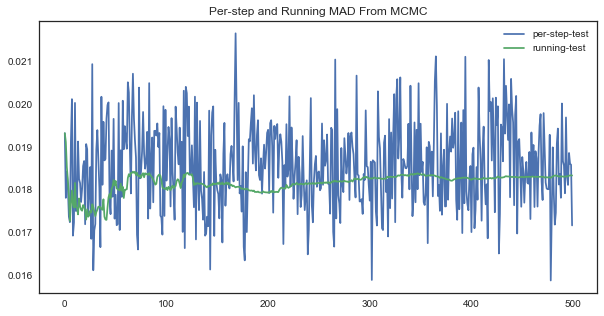

In [38]:
# m1_trace=model1(insample,2)
# results = {'per-step-test': [], 'running-test': []}
# y_hat=np.zeros((len(outsample),))
# for cnt,sample in enumerate(m1_trace):    
#     sample_y = pred1(sample['a'], sample['b'],outsample)
#     y_hat += sample_y
#     running_y = y_hat / (cnt + 1)
#     results['per-step-test'].append(MAD(outsample.sales_actual_yoy, sample_y))
#     results['running-test'].append(MAD(outsample.sales_actual_yoy, running_y))
# results = pd.DataFrame(results)
# results.plot(kind='line', grid=False, figsize=(10, 5),title='Per-step and Running MAD From MCMC')
# plt.show()

Model 2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, eps_a, gamma_1, gamma_0, sigma_a_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:51<00:00, 19.25it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


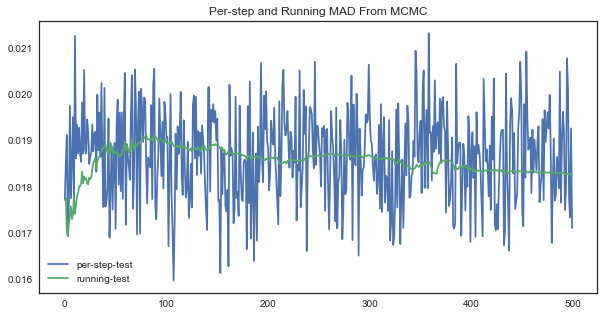

In [39]:
# benchmark=insample.groupby('tab')['sales_actual_yoy'].mean().values
# benchmark_lookup=dict(zip(tabs, benchmark))
# insample['initial']=insample.tab.replace(benchmark_lookup).values
# m2_trace=model2(insample,2)

# results = {'per-step-test': [], 'running-test': []}
# y_hat=np.zeros((len(outsample),))
# for cnt,sample in enumerate(m2_trace):    
#     sample_y = pred2(sample['gamma_0'],sample['gamma_1'],sample['eps_a'],sample['b'],outsample,benchmark)
#     y_hat += sample_y
#     running_y = y_hat / (cnt + 1)
#     results['per-step-test'].append(MAD(outsample.sales_actual_yoy, sample_y))
#     results['running-test'].append(MAD(outsample.sales_actual_yoy, running_y))
# results = pd.DataFrame(results)
# results.plot(kind='line', grid=False, figsize=(10, 5),title='Per-step and Running MAD From MCMC')
# plt.show()

Model 3

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_log__, b, a, sigma_b_log__, mu_b]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.54it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


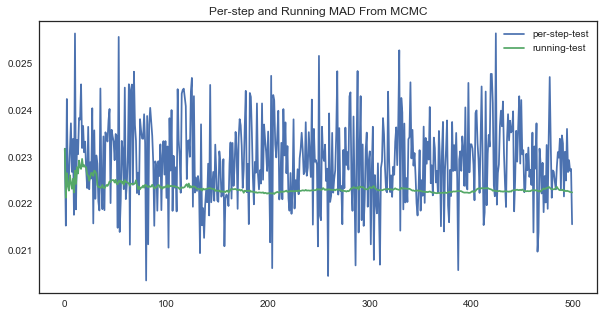

In [40]:
# m3_trace=model3(insample,2)
# results = {'per-step-test': [], 'running-test': []}
# y_hat=np.zeros((len(outsample),))
# for cnt,sample in enumerate(m3_trace):    
#     sample_y = pred3(sample['a'], sample['b'],outsample)
#     y_hat += sample_y
#     running_y = y_hat / (cnt + 1)
#     results['per-step-test'].append(MAD(outsample.sales_actual_yoy, sample_y))
#     results['running-test'].append(MAD(outsample.sales_actual_yoy, running_y))
# results = pd.DataFrame(results)
# results.plot(kind='line', grid=False, figsize=(10, 5),title='Per-step and Running MAD From MCMC')
# plt.show()

Model 4

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, a, eps_b, gamma_1, gamma_0, sigma_b_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 21.91it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


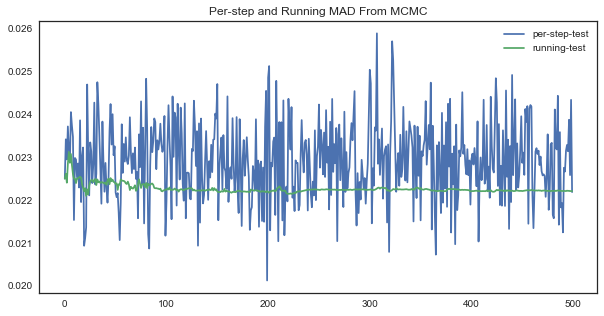

In [41]:
# benchmark=insample.groupby('tab')['sales_actual_yoy'].mean().values
# benchmark_lookup=dict(zip(tabs, benchmark))
# insample['initial']=insample.tab.replace(benchmark_lookup).values
# m4_trace=model4(insample,2)

# results = {'per-step-test': [], 'running-test': []}
# y_hat=np.zeros((len(outsample),))
# for cnt,sample in enumerate(m4_trace):    
#     sample_y = pred4(sample['gamma_0'],sample['gamma_1'],sample['a'],sample['eps_b'],outsample,benchmark)
#     y_hat += sample_y
#     running_y = y_hat / (cnt + 1)
#     results['per-step-test'].append(MAD(outsample.sales_actual_yoy, sample_y))
#     results['running-test'].append(MAD(outsample.sales_actual_yoy, running_y))
# results = pd.DataFrame(results)
# results.plot(kind='line', grid=False, figsize=(10, 5),title='Per-step and Running MAD From MCMC')
# plt.show()

Model 5

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.84it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


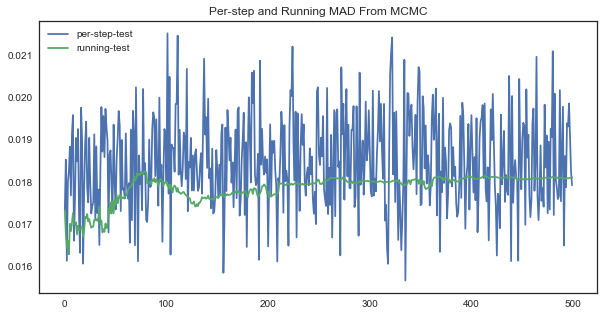

In [42]:
# m5_trace=model5(insample,2)
# results = {'per-step-test': [], 'running-test': []}
# y_hat=np.zeros((len(outsample),))
# for cnt,sample in enumerate(m5_trace):    
#     sample_y = pred5(sample['a'], sample['b'],outsample)
#     y_hat += sample_y
#     running_y = y_hat / (cnt + 1)
#     results['per-step-test'].append(MAD(outsample.sales_actual_yoy, sample_y))
#     results['running-test'].append(MAD(outsample.sales_actual_yoy, running_y))
# results = pd.DataFrame(results)
# results.plot(kind='line', grid=False, figsize=(10, 5),title='Per-step and Running MAD From MCMC')
# plt.show()

Model 6

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, eps_b, eps_a, gamma_3, gamma_2, sigma_b_log__, gamma_1, gamma_0, sigma_a_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [01:30<00:00, 16.63it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


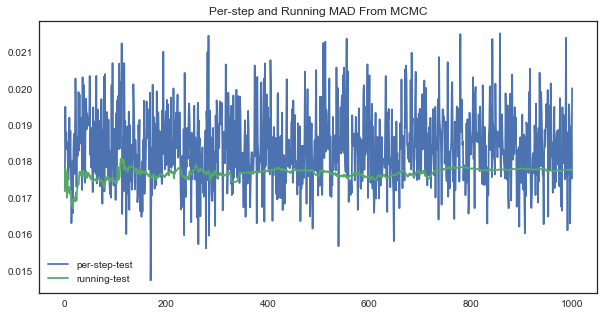

In [43]:
# benchmark=insample.groupby('tab')['sales_actual_yoy'].mean().values
# benchmark_lookup=dict(zip(tabs, benchmark))
# insample['initial']=insample.tab.replace(benchmark_lookup).values
# m6_trace=model6(insample,2)

# results = {'per-step-test': [], 'running-test': []}
# y_hat=np.zeros((len(outsample),))
# for cnt,sample in enumerate(m6_trace):    
#     sample_y = pred6(sample['gamma_0'],sample['gamma_1'],sample['gamma_2'],
#                        sample['gamma_3'],sample['eps_a'],sample['eps_b'],outsample,benchmark)
#     y_hat += sample_y
#     running_y = y_hat / (cnt + 1)
#     results['per-step-test'].append(MAD(outsample.sales_actual_yoy, sample_y))
#     results['running-test'].append(MAD(outsample.sales_actual_yoy, running_y))
# results = pd.DataFrame(results)
# results.plot(kind='line', grid=False, figsize=(10, 5),title='Per-step and Running MAD From MCMC')
# plt.show()

<strong>Fixed Rolling Window Forecast</strong>

In [37]:
#MAP
for i in range(1,7):
    print('MODEL'+str(i)+' RUNNING:')
    if i%2!=0:
        error=model_running(i)
        locals()['in_error_m'+str(i)+'_fix']=error[0]
        locals()['out_error_m'+str(i)+'_fix']=error[1]
    else:
        error=model_running_benchmark(i)
        locals()['in_error_m'+str(i)+'_fix']=error[0]
        locals()['out_error_m'+str(i)+'_fix']=error[1]

MODEL1 RUNNING:


logp = 1,593.5, ||grad|| = 2.2225: 100%|██████████████████████████████████████████████| 89/89 [00:00<00:00, 598.34it/s]
logp = 1,561.6, ||grad|| = 0.091164: 100%|████████████████████████████████████████████| 73/73 [00:00<00:00, 934.33it/s]
logp = 1,515.6, ||grad|| = 0.80878: 100%|████████████████████████████████████████████| 79/79 [00:00<00:00, 1151.05it/s]
logp = 1,457, ||grad|| = 0.31203: 100%|███████████████████████████████████████████████| 77/77 [00:00<00:00, 879.44it/s]
logp = 1,425.6, ||grad|| = 0.94552: 100%|████████████████████████████████████████████| 77/77 [00:00<00:00, 1103.56it/s]
logp = 1,431.4, ||grad|| = 3.472: 100%|██████████████████████████████████████████████| 71/71 [00:00<00:00, 1148.19it/s]
logp = 1,436.6, ||grad|| = 0.63133: 100%|████████████████████████████████████████████| 74/74 [00:00<00:00, 1725.44it/s]
logp = 1,426, ||grad|| = 0.28849: 100%|██████████████████████████████████████████████| 73/73 [00:00<00:00, 1591.20it/s]
logp = 1,415.8, ||grad|| = 0.51488: 100%

MODEL2 RUNNING:


logp = 1,575.1, ||grad|| = 7.4993: 100%|███████████████████████████████████████████| 224/224 [00:00<00:00, 1234.26it/s]
logp = 1,543.4, ||grad|| = 6.9821: 100%|███████████████████████████████████████████| 226/226 [00:00<00:00, 1348.80it/s]
logp = 1,497.3, ||grad|| = 1.2313: 100%|███████████████████████████████████████████| 204/204 [00:00<00:00, 1354.44it/s]
logp = 1,439, ||grad|| = 1.7695: 100%|█████████████████████████████████████████████| 217/217 [00:00<00:00, 1279.87it/s]
logp = 1,407.8, ||grad|| = 1.3427: 100%|███████████████████████████████████████████| 225/225 [00:00<00:00, 1281.83it/s]
logp = 1,413.5, ||grad|| = 1.4606: 100%|███████████████████████████████████████████| 197/197 [00:00<00:00, 1371.69it/s]
logp = 1,418.5, ||grad|| = 0.88587: 100%|██████████████████████████████████████████| 239/239 [00:00<00:00, 1264.45it/s]
logp = 1,407.9, ||grad|| = 2.591: 100%|████████████████████████████████████████████| 139/139 [00:00<00:00, 1327.29it/s]
logp = 1,397.7, ||grad|| = 1.0214: 100%|

MODEL3 RUNNING:


logp = 1,273.8, ||grad|| = 6.6071: 100%|███████████████████████████████████████████| 467/467 [00:00<00:00, 1373.27it/s]
logp = 1,271.3, ||grad|| = 1.2357: 100%|███████████████████████████████████████████| 472/472 [00:00<00:00, 1363.85it/s]
logp = 1,261.4, ||grad|| = 10.531: 100%|███████████████████████████████████████████| 400/400 [00:00<00:00, 1397.45it/s]
logp = 1,242.4, ||grad|| = 0.92106: 100%|██████████████████████████████████████████| 404/404 [00:00<00:00, 1350.27it/s]
logp = 1,223.4, ||grad|| = 0.2948: 100%|███████████████████████████████████████████| 465/465 [00:00<00:00, 1395.93it/s]
logp = 1,222.8, ||grad|| = 0.77549: 100%|██████████████████████████████████████████| 430/430 [00:00<00:00, 1368.73it/s]
logp = 1,218.4, ||grad|| = 0.3048: 100%|███████████████████████████████████████████| 388/388 [00:00<00:00, 1341.51it/s]
logp = 1,206.8, ||grad|| = 0.54978: 100%|██████████████████████████████████████████| 347/347 [00:00<00:00, 1375.17it/s]
logp = 1,199.4, ||grad|| = 0.66959: 100%

MODEL4 RUNNING:


logp = 1,258.8, ||grad|| = 1.2567: 100%|███████████████████████████████████████████| 554/554 [00:00<00:00, 1335.30it/s]
logp = 1,256.4, ||grad|| = 11.028: 100%|███████████████████████████████████████████| 496/496 [00:00<00:00, 1240.21it/s]
logp = 1,246.4, ||grad|| = 0.37257: 100%|██████████████████████████████████████████| 456/456 [00:00<00:00, 1298.92it/s]
logp = 1,227.4, ||grad|| = 0.49617: 100%|██████████████████████████████████████████| 520/520 [00:00<00:00, 1340.33it/s]
logp = 1,208.4, ||grad|| = 1.7957: 100%|███████████████████████████████████████████| 429/429 [00:00<00:00, 1272.63it/s]
logp = 1,207.8, ||grad|| = 0.67432: 100%|██████████████████████████████████████████| 468/468 [00:00<00:00, 1333.09it/s]
logp = 1,203.4, ||grad|| = 45.265: 100%|███████████████████████████████████████████| 373/373 [00:00<00:00, 1326.22it/s]
logp = 1,191.9, ||grad|| = 0.28757: 100%|██████████████████████████████████████████| 458/458 [00:00<00:00, 1237.80it/s]
logp = 1,184.4, ||grad|| = 1.9923: 100%|

MODEL5 RUNNING:


logp = 1,674.3, ||grad|| = 5.9717: 100%|███████████████████████████████████████████| 376/376 [00:00<00:00, 1239.19it/s]
logp = 1,648.8, ||grad|| = 0.69063: 100%|██████████████████████████████████████████| 354/354 [00:00<00:00, 1215.57it/s]
logp = 1,608.9, ||grad|| = 0.36499: 100%|██████████████████████████████████████████| 343/343 [00:00<00:00, 1250.61it/s]
logp = 1,554, ||grad|| = 1.1041: 100%|█████████████████████████████████████████████| 341/341 [00:00<00:00, 1199.68it/s]
logp = 1,515.8, ||grad|| = 1.6891: 100%|███████████████████████████████████████████| 357/357 [00:00<00:00, 1158.43it/s]
logp = 1,519.8, ||grad|| = 1.1401: 100%|███████████████████████████████████████████| 368/368 [00:00<00:00, 1205.82it/s]
logp = 1,525.2, ||grad|| = 0.73747: 100%|██████████████████████████████████████████| 397/397 [00:00<00:00, 1181.19it/s]
logp = 1,618.5, ||grad|| = 21,739: 100%|███████████████████████████████████████████| 563/563 [00:00<00:00, 1235.24it/s]
logp = 1,680.3, ||grad|| = 1.4655e+07: 1

MODEL6 RUNNING:


logp = 1,653.4, ||grad|| = 0.99403: 100%|████████████████████████████████████████| 1139/1139 [00:01<00:00, 1105.56it/s]
logp = 1,628.7, ||grad|| = 0.97888: 100%|████████████████████████████████████████| 1065/1065 [00:00<00:00, 1121.69it/s]
logp = 1,589.9, ||grad|| = 5.0783: 100%|███████████████████████████████████████████| 967/967 [00:00<00:00, 1095.61it/s]
logp = 1,536.6, ||grad|| = 2.6904: 100%|█████████████████████████████████████████| 1059/1059 [00:00<00:00, 1091.29it/s]
logp = 1,897.8, ||grad|| = 1.4584e+05: 100%|█████████████████████████████████████| 1204/1204 [00:01<00:00, 1015.32it/s]
logp = 1,685.4, ||grad|| = 69,430: 100%|███████████████████████████████████████████| 836/836 [00:00<00:00, 1119.13it/s]
logp = 1,640.3, ||grad|| = 2.266e+07: 100%|████████████████████████████████████████| 888/888 [00:00<00:00, 1076.64it/s]
logp = 1,717.7, ||grad|| = 8,581.9: 100%|██████████████████████████████████████████| 813/813 [00:00<00:00, 1200.55it/s]
logp = 1,701.2, ||grad|| = 1.5517e+05: 1

In [38]:
#MCMC
for i in range(1,7):
    print('MODEL'+str(i)+' RUNNING:')
    if i%2!=0:
        error=model_running_SAMPLE(i,2)
        locals()['in_error_m'+str(i)+'_fix_MCMC']=error[0]
        locals()['out_error_m'+str(i)+'_fix_MCMC']=error[1]
    else:
        error=model_running_benchmark_SAMPLE(i,2)
        locals()['in_error_m'+str(i)+'_fix_MCMC']=error[0]
        locals()['out_error_m'+str(i)+'_fix_MCMC']=error[1]

MODEL1 RUNNING:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_a_log__, mu_a]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 371.03it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_a_log__, mu_a]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 393.48it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_a_log__, mu_a]
100%|█████████████████████████████████████████████████████████████████████████████

Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_a_log__, mu_a]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 427.68it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_a_log__, mu_a]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 391.41it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_a_log__, mu_a

MODEL2 RUNNING:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, eps_a, gamma_1, gamma_0, sigma_a_log__]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.79it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, eps_a, gamma_1, gamma_0, sigma_a_log__]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 100.65it/s]
The acceptance probability does not match the target. It is 0.878974822135, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag

NUTS: [sigma_y_interval__, b, eps_a, gamma_1, gamma_0, sigma_a_log__]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 143.51it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, eps_a, gamma_1, gamma_0, sigma_a_log__]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 126.88it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, eps_a, gamma_1, gamma_0, sigma_a_log__]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.70it/s]
Only one chain was sampled, th

The acceptance probability does not match the target. It is 0.904098675875, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, eps_a, gamma_1, gamma_0, sigma_a_log__]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 107.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


MODEL3 RUNNING:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_log__, b, a, sigma_b_log__, mu_b]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 199.46it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_log__, b, a, sigma_b_log__, mu_b]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 211.65it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_log__, b, a, sigma_b_log__, mu_b]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_log__, b, a, sigma_b_log__, mu_b]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 177.15it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_log__, b, a, sigma_b_log__, mu_b]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 198.28it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_log__, b, a, sigma_b_log__, mu_b]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.00it/s]
Only one

MODEL4 RUNNING:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, a, eps_b, gamma_1, gamma_0, sigma_b_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.12it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, a, eps_b, gamma_1, gamma_0, sigma_b_log__]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.72it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, a, eps_b, gamma_1, gamma_0, sigma_b_log__]
100%|█████████████████████████████

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, a, eps_b, gamma_1, gamma_0, sigma_b_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.44it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, a, eps_b, gamma_1, gamma_0, sigma_b_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 79.40it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, a, eps_b, gamma_1, gamma_0, sigma_b_log__]
100%|████████████████████████████████████████████████████████████

MODEL5 RUNNING:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.72it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.65it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
100%|██████████████

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 90.89it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 96.84it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-a

MODEL6 RUNNING:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, eps_b, eps_a, gamma_3, gamma_2, sigma_b_log__, gamma_1, gamma_0, sigma_a_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:24<00:00, 62.02it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, eps_b, eps_a, gamma_3, gamma_2, sigma_b_log__, gamma_1, gamma_0, sigma_a_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:23<00:00, 63.03it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, eps

Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, eps_b, eps_a, gamma_3, gamma_2, sigma_b_log__, gamma_1, gamma_0, sigma_a_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:27<00:00, 55.18it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, eps_b, eps_a, gamma_3, gamma_2, sigma_b_log__, gamma_1, gamma_0, sigma_a_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:26<00:00, 55.85it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, eps_b, eps_a, gamma_3, gamma_2, sigma_b_log__, gamma_1, gamma_0, sigma_a_log__]

In [39]:
#ADVI
# for i in range(1,7):
#     print('MODEL'+str(i)+' RUNNING:')
#     if i%2!=0:
#         error=model_running_SAMPLE(i,3)
#         locals()['in_error_m'+str(i)+'_fix_ADVI']=error[0]
#         locals()['out_error_m'+str(i)+'_fix_ADVI']=error[1]
#     else:
#         error=model_running_benchmark_SAMPLE(i,3)
#         locals()['in_error_m'+str(i)+'_fix_ADVI']=error[0]
#         locals()['out_error_m'+str(i)+'_fix_ADVI']=error[1]

<strong>Recursive Rolling Window Forecast</strong>

In [40]:
#MAP
for i in range(1,7):
    print('MODEL'+str(i)+' RUNNING:')
    if i%2!=0:
        error=model_running_add(i)
        locals()['in_error_m'+str(i)+'_rec']=error[0]
        locals()['out_error_m'+str(i)+'_rec']=error[1]
    else:
        error=model_running_add_benchmark(i)
        locals()['in_error_m'+str(i)+'_rec']=error[0]
        locals()['out_error_m'+str(i)+'_rec']=error[1]

MODEL1 RUNNING:


logp = 1,593.5, ||grad|| = 2.2225: 100%|█████████████████████████████████████████████| 89/89 [00:00<00:00, 1993.33it/s]
logp = 1,588.8, ||grad|| = 10.035: 100%|█████████████████████████████████████████████| 71/71 [00:00<00:00, 1736.16it/s]
logp = 1,563, ||grad|| = 5.4705: 100%|███████████████████████████████████████████████| 69/69 [00:00<00:00, 1921.67it/s]
logp = 1,567.2, ||grad|| = 0.5793: 100%|█████████████████████████████████████████████| 64/64 [00:00<00:00, 1645.25it/s]
logp = 1,600.9, ||grad|| = 0.36772: 100%|████████████████████████████████████████████| 64/64 [00:00<00:00, 1944.37it/s]
logp = 1,669, ||grad|| = 0.41533: 100%|██████████████████████████████████████████████| 65/65 [00:00<00:00, 1916.65it/s]
logp = 1,743.2, ||grad|| = 9.0043: 100%|█████████████████████████████████████████████| 61/61 [00:00<00:00, 2108.82it/s]
logp = 1,806.5, ||grad|| = 2.8174: 100%|█████████████████████████████████████████████| 67/67 [00:00<00:00, 2035.51it/s]
logp = 1,834.4, ||grad|| = 0.35343: 100%

MODEL2 RUNNING:


logp = 1,575.1, ||grad|| = 7.4993: 100%|███████████████████████████████████████████| 224/224 [00:00<00:00, 1639.43it/s]
logp = 1,570.6, ||grad|| = 0.63719: 100%|██████████████████████████████████████████| 205/205 [00:00<00:00, 1624.22it/s]
logp = 1,544.8, ||grad|| = 1.2619: 100%|███████████████████████████████████████████| 192/192 [00:00<00:00, 1689.16it/s]
logp = 1,549.1, ||grad|| = 0.30842: 100%|██████████████████████████████████████████| 182/182 [00:00<00:00, 1705.47it/s]
logp = 1,582.9, ||grad|| = 1.2554: 100%|███████████████████████████████████████████| 178/178 [00:00<00:00, 1565.57it/s]
logp = 1,651.1, ||grad|| = 0.81151: 100%|██████████████████████████████████████████| 165/165 [00:00<00:00, 1590.73it/s]
logp = 1,725.2, ||grad|| = 2.3506: 100%|███████████████████████████████████████████| 176/176 [00:00<00:00, 1640.83it/s]
logp = 1,788.6, ||grad|| = 1.0192: 100%|███████████████████████████████████████████| 150/150 [00:00<00:00, 1617.12it/s]
logp = 1,816.6, ||grad|| = 0.91729: 100%

MODEL3 RUNNING:


logp = 1,273.8, ||grad|| = 6.6071: 100%|███████████████████████████████████████████| 467/467 [00:00<00:00, 1780.40it/s]
logp = 1,290.6, ||grad|| = 1.5802: 100%|███████████████████████████████████████████| 390/390 [00:00<00:00, 1730.28it/s]
logp = 1,291.5, ||grad|| = 4.4228: 100%|███████████████████████████████████████████| 331/331 [00:00<00:00, 1580.38it/s]
logp = 1,325.6, ||grad|| = 0.35998: 100%|██████████████████████████████████████████| 389/389 [00:00<00:00, 1725.84it/s]
logp = 1,365.5, ||grad|| = 1.5496: 100%|███████████████████████████████████████████| 336/336 [00:00<00:00, 1782.50it/s]
logp = 1,431.9, ||grad|| = 0.33715: 100%|██████████████████████████████████████████| 312/312 [00:00<00:00, 1907.53it/s]
logp = 1,501.3, ||grad|| = 0.44888: 100%|██████████████████████████████████████████| 313/313 [00:00<00:00, 1724.37it/s]
logp = 1,573.6, ||grad|| = 5.089: 100%|████████████████████████████████████████████| 338/338 [00:00<00:00, 1711.61it/s]
logp = 1,614.2, ||grad|| = 0.76961: 100%

MODEL4 RUNNING:


logp = 1,258.8, ||grad|| = 1.2567: 100%|███████████████████████████████████████████| 554/554 [00:00<00:00, 1643.42it/s]
logp = 1,275.6, ||grad|| = 0.52321: 100%|██████████████████████████████████████████| 596/596 [00:00<00:00, 1618.18it/s]
logp = 1,276.6, ||grad|| = 78.195: 100%|███████████████████████████████████████████| 530/530 [00:00<00:00, 1719.78it/s]
logp = 1,310.7, ||grad|| = 1.681: 100%|████████████████████████████████████████████| 729/729 [00:00<00:00, 1692.02it/s]
logp = 1,350.7, ||grad|| = 2.3491: 100%|███████████████████████████████████████████| 715/715 [00:00<00:00, 1710.99it/s]
logp = 1,416.9, ||grad|| = 308.69: 100%|███████████████████████████████████████████| 491/491 [00:00<00:00, 1709.41it/s]
logp = 1,486.4, ||grad|| = 2.1593: 100%|███████████████████████████████████████████| 394/394 [00:00<00:00, 1639.20it/s]
logp = 1,558.6, ||grad|| = 0.58694: 100%|██████████████████████████████████████████| 379/379 [00:00<00:00, 1678.89it/s]
logp = 1,599.2, ||grad|| = 1.2939: 100%|

MODEL5 RUNNING:


logp = 1,674.3, ||grad|| = 5.9717: 100%|███████████████████████████████████████████| 376/376 [00:00<00:00, 1496.04it/s]
logp = 1,668.2, ||grad|| = 0.8919: 100%|███████████████████████████████████████████| 408/408 [00:00<00:00, 1598.00it/s]
logp = 1,635.8, ||grad|| = 0.8049: 100%|███████████████████████████████████████████| 397/397 [00:00<00:00, 1473.37it/s]
logp = 1,638.3, ||grad|| = 0.30079: 100%|██████████████████████████████████████████| 383/383 [00:00<00:00, 1505.96it/s]
logp = 1,674, ||grad|| = 1.136: 100%|██████████████████████████████████████████████| 400/400 [00:00<00:00, 1623.76it/s]
logp = 1,749.8, ||grad|| = 3.6973: 100%|███████████████████████████████████████████| 381/381 [00:00<00:00, 1463.65it/s]
logp = 1,828.8, ||grad|| = 0.83737: 100%|██████████████████████████████████████████| 399/399 [00:00<00:00, 1556.66it/s]
logp = 1,908.8, ||grad|| = 0.42516: 100%|██████████████████████████████████████████| 412/412 [00:00<00:00, 1459.73it/s]
logp = 1,952.8, ||grad|| = 0.79682: 100%

MODEL6 RUNNING:


logp = 1,653.4, ||grad|| = 0.99403: 100%|████████████████████████████████████████| 1139/1139 [00:00<00:00, 1475.51it/s]
logp = 1,648.1, ||grad|| = 1.0176: 100%|█████████████████████████████████████████| 1046/1046 [00:00<00:00, 1430.97it/s]
logp = 1,692.6, ||grad|| = 6.0293e+06: 100%|███████████████████████████████████████| 946/946 [00:00<00:00, 1482.08it/s]
logp = 1,769.5, ||grad|| = 1.5245e+07: 100%|███████████████████████████████████████| 787/787 [00:00<00:00, 1464.10it/s]
logp = 1,881.9, ||grad|| = 2.4412e+07: 100%|███████████████████████████████████████| 855/855 [00:00<00:00, 1455.49it/s]
logp = 1,894.6, ||grad|| = 2.1821e+05: 100%|███████████████████████████████████████| 905/905 [00:00<00:00, 1298.17it/s]
logp = 2,170.3, ||grad|| = 5.6128e+08: 100%|█████████████████████████████████████| 1261/1261 [00:00<00:00, 1458.33it/s]
logp = 1,889, ||grad|| = 5.2074: 100%|█████████████████████████████████████████████| 841/841 [00:00<00:00, 1441.45it/s]
logp = 1,931.9, ||grad|| = 1.9699: 100%|

In [41]:
#MCMC
for i in range(1,7):
    print('MODEL'+str(i)+' RUNNING:')
    if i%2!=0:
        error=model_running_add_SAMPLE(i,2)
        locals()['in_error_m'+str(i)+'_rec_MCMC']=error[0]
        locals()['out_error_m'+str(i)+'_rec_MCMC']=error[1]
    else:
        error=model_running_add_benchmark_SAMPLE(i,2)
        locals()['in_error_m'+str(i)+'_rec_MCMC']=error[0]
        locals()['out_error_m'+str(i)+'_rec_MCMC']=error[1]

MODEL1 RUNNING:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_a_log__, mu_a]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 361.65it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_a_log__, mu_a]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 401.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_a_log__, mu_a]
100%|█████████████████████████████████████████████████████████████████████████████

Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_a_log__, mu_a]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 388.30it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_a_log__, mu_a]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 355.51it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_a_log__, mu_a

MODEL2 RUNNING:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, eps_a, gamma_1, gamma_0, sigma_a_log__]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.32it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, eps_a, gamma_1, gamma_0, sigma_a_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.31it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, eps_a, gamma_1, gamma_0, sigma_a_log__]
100%|█████████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.30it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, eps_a, gamma_1, gamma_0, sigma_a_log__]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.63it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, eps_a, gamma_1, gamma_0, sigma_a_log__]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 133.35it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning N

MODEL3 RUNNING:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_log__, b, a, sigma_b_log__, mu_b]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.77it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_log__, b, a, sigma_b_log__, mu_b]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 151.47it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_log__, b, a, sigma_b_log__, mu_b]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_log__, b, a, sigma_b_log__, mu_b]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_log__, b, a, sigma_b_log__, mu_b]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 140.67it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_log__, b, a, sigma_b_log__, mu_b]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.26it/s]
Only one

MODEL4 RUNNING:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, a, eps_b, gamma_1, gamma_0, sigma_b_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.12it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, a, eps_b, gamma_1, gamma_0, sigma_b_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 95.22it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, a, eps_b, gamma_1, gamma_0, sigma_b_log__]
100%|█████████████████████████████

The acceptance probability does not match the target. It is 0.893745841862, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, a, eps_b, gamma_1, gamma_0, sigma_b_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.60it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, a, eps_b, gamma_1, gamma_0, sigma_b_log__]
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.95it/s]
Only one chain was sampled, this makes it impossible to run some converg

MODEL5 RUNNING:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 91.17it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.19it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
100%|██████████████

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 92.00it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.65it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, b, a, sigma_b_log__, mu_b, sigma_a_log__, mu_a]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 89.50it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-a

MODEL6 RUNNING:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, eps_b, eps_a, gamma_3, gamma_2, sigma_b_log__, gamma_1, gamma_0, sigma_a_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:24<00:00, 60.65it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, eps_b, eps_a, gamma_3, gamma_2, sigma_b_log__, gamma_1, gamma_0, sigma_a_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:23<00:00, 63.31it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, eps

Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, eps_b, eps_a, gamma_3, gamma_2, sigma_b_log__, gamma_1, gamma_0, sigma_a_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:23<00:00, 63.60it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, eps_b, eps_a, gamma_3, gamma_2, sigma_b_log__, gamma_1, gamma_0, sigma_a_log__]
100%|██████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:24<00:00, 61.94it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_y_interval__, eps_b, eps_a, gamma_3, gamma_2, sigma_b_log__, gamma_1, gamma_0, sigma_a_log__]

In [42]:
#ADVI
# for i in range(1,7):
#     print('MODEL'+str(i)+' RUNNING:')
#     if i%2!=0:
#         error=model_running_add_SAMPLE(i,3)
#         locals()['in_error_m'+str(i)+'_rec_ADVI']=error[0]
#         locals()['out_error_m'+str(i)+'_rec_ADVI']=error[1]
#     else:
#         error=model_running_add_benchmark_SAMPLE(i,3)
#         locals()['in_error_m'+str(i)+'_rec_ADVI']=error[0]
#         locals()['out_error_m'+str(i)+'_rec_ADVI']=error[1]

<h3>Result</h3>

In [48]:
in_error_main=np.median(np.abs(insample.pred_sales_yoy_main-insample.sales_actual_yoy))
in_error_ss=np.median(np.abs(insample.pred_sales_yoy_ss-insample.sales_actual_yoy))
out_error_main=np.median(np.abs(outsample.pred_sales_yoy_main-outsample.sales_actual_yoy))
out_error_ss=np.median(np.abs(outsample.pred_sales_yoy_ss-outsample.sales_actual_yoy))

<strong>Model1</strong>:Varying intercept without Hierachical Model  
<strong>Model2</strong>:Hierachical Varying intercept Model  
<strong>Model3</strong>:Varying slope without Hierachical Model  
<strong>Model4</strong>:Hierachical Varying slope Model  
<strong>Model5</strong>:Varying slope and intercept without Hierachical Model  
<strong>Model6</strong>:Hierachical Varying slope and intercept Model

<strong>insample error</strong>

In [58]:
result_insample=pd.DataFrame(columns=['MAP(Fixed_Roll)','MAP(Recursive)','MCMC(Fixed_Roll)','MCMC(Recursive)'])
result_insample.loc['main']=[in_error_main]*4
result_insample.loc['ss']=[in_error_ss]*4
for i in range(1,7):
    result_insample.loc['model'+str(i)]=[eval('in_error_m'+str(i)+'_fix.values.mean()'),eval('in_error_m'+str(i)+'_rec.values.mean()'),
                                   eval('in_error_m'+str(i)+'_fix_MCMC.values.mean()'),eval('in_error_m'+str(i)+'_rec_MCMC.values.mean()')]

In [60]:
result_insample

,MAP(Fixed_Roll),MAP(Recursive),MCMC(Fixed_Roll),MCMC(Recursive)
main,0.015660,0.015660,0.015660,0.015660
ss,0.012963,0.012963,0.012963,0.012963
model1,0.010522,0.011918,0.010523,0.011926
model2,0.010513,0.012019,0.012019,0.010500
model3,0.013890,0.014863,0.013814,0.014852
model4,0.013918,0.014998,0.014982,0.013860
model5,0.009083,0.009812,0.008093,0.009697
model6,0.009304,0.010939,0.009800,0.008073


<strong>outsample error</strong>

In [61]:
result_all=pd.DataFrame(columns=['MAP(Fixed_Roll)','MAP(Recursive)','MCMC(Fixed_Roll)','MCMC(Recursive)'])
result_all.loc['main']=[out_error_main]*4
result_all.loc['ss']=[out_error_ss]*4
for i in range(1,7):
    result_all.loc['model'+str(i)]=[eval('out_error_m'+str(i)+'_fix'),eval('out_error_m'+str(i)+'_rec'),
                                   eval('out_error_m'+str(i)+'_fix_MCMC'),eval('out_error_m'+str(i)+'_rec_MCMC')]

In [62]:
pd.set_option('precision', 8)
result_all

,MAP(Fixed_Roll),MAP(Recursive),MCMC(Fixed_Roll),MCMC(Recursive)
main,0.01739046,0.01739046,0.01739046,0.01739046
ss,0.01601296,0.01601296,0.01601296,0.01601296
model1,0.01325268,0.01527020,0.01331946,0.01537553
model2,0.01322811,0.01545993,0.01538828,0.01313409
model3,0.01783044,0.02012276,0.01799945,0.02013942
model4,0.01776548,0.02013245,0.02006977,0.01775583
model5,0.01167963,0.01462006,0.01180765,0.01469320
model6,0.01225775,0.01559670,0.01487334,0.01168951
